# APOE ANALYZE WORKFOLW

In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Imports

In [48]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation
from alphagenome.data import genome
from alphagenome.data import transcript as transcript_utils
from alphagenome.data import track_data
from alphagenome.interpretation import ism
from alphagenome.models import dna_client
from alphagenome.models import variant_scorers
from alphagenome.visualization import plot_components
from google.colab import data_table, files
import matplotlib.pyplot as plt
import pandas as pd

```{tip}
If using Google Colab, store your key in "Secrets" for persistent access across sessions (see [installation](https://www.alphagenomedocs.com/installation.html#google-colab)). Otherwise, `dna_client.create` can take the API key directly.
```

## Setup

In [30]:
dna_model = dna_client.create(colab_utils.get_api_key())

The model can make predictions for the following
[output types](https://www.alphagenomedocs.com/exploring_model_metadata.html):

In [31]:
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

# Predict outputs for APOE genome interval (reference genome)

We first load up a GTF file containing gene and transcript locations as
annotated by GENCODE (more information on GTF format
[here](https://www.gencodegenes.org/pages/data_format.html)):

In [32]:
# The GTF file contains information on the location of all trancripts.
# Note that we use genome assembly hg38 for human.
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Set up transcript extractors using the information in the GTF file.
# Mane select transcripts consists of of one curated transcript per locus.
gtf_transcripts = gene_annotation.filter_protein_coding(gtf)
gtf_transcripts = gene_annotation.filter_to_mane_select_transcript(gtf_transcripts)
transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcripts)

And then fetch the gene's location as a `genome.Interval` object by passing
either its `gene_symbol` (HGNC naming convention) or ENSEMBL `gene_id`:

In [33]:
interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOE')
interval

Interval(chromosome='chr19', start=44905790, end=44909393, strand='+', name='APOE')

We can resize it to a length compatible with the model:

In [34]:
interval = interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

The `.resize()` method adjusts the interval to the specified width by expanding
(or contracting) around its original center. Note that
`dna_model.predict_interval()` interprets this resizing as an expansion of the
actual genomic sequence rather than padding tokens.

In [35]:
interval.width

1048576

See the
[essential commands documentation](https://www.alphagenomedocs.com/colabs/essential_commands.html)
for more handy commands like `resize`.

Note that AlphaGenome supports the following input sequence lengths:

In [36]:
dna_client.SUPPORTED_SEQUENCE_LENGTHS.keys()

dict_keys(['SEQUENCE_LENGTH_16KB', 'SEQUENCE_LENGTH_100KB', 'SEQUENCE_LENGTH_500KB', 'SEQUENCE_LENGTH_1MB'])

We can now make predictions using our interval.

To characterize the tissue-specific regulatory architecture of the APOE locus using AlphaGenome, we employed a multi-modal selection of UBERON and Cell Ontology (CL) terms. We prioritized the Hippocampus (UBERON:0001954) and Dorsolateral Prefrontal Cortex (UBERON:0009834) as these regions represent the primary clinicopathological epicenters of Alzheimer's Disease, exhibiting early amyloid-β deposition and significant transcriptomic dysregulation. Recognizing that APOE serves as a dual-function lipid transporter, we integrated the Liver (UBERON:0002107) to capture the peripheral regulatory signals that govern systemic cholesterol metabolism. Furthermore, to refine AlphaGenome's predictions of chromatin accessibility and isoform-specific expression, we utilized cell-type-specific ontologies for Astrocytes (CL:0000127) and Microglia (CL:0000129). This approach ensures that the model interprets genetic variants within the specific epigenetic contexts of the primary cellular drivers of neuroinflammation and lipid transport, thereby maximizing the physiological relevance of the predicted functional impacts.

In [37]:
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs=[dna_client.OutputType.RNA_SEQ],
    ontology_terms=['UBERON:0009834', # DLPFC (Brain)
    'UBERON:0001954', # Hippocampus (Brain)
    'UBERON:0002107', # Liver (Peripheral)
    'CL:0000127']      # Astrocytes (Cell type),
)

output.rna_seq.values.shape

(1048576, 11)

In general, you can have multiple tracks for a given ontology term. In this
case, we have 3 RNA-seq tracks for the tissue "Right liver lobe".

Let's visualise these predictions. It's helpful visualise gene transcripts
alongside the predicted tracks, so we extract them here:

In [38]:
transcripts = transcript_extractor.extract(interval)
print(f'Extracted {len(transcripts)} transcripts in this interval.')

Extracted 34 transcripts in this interval.


We also provide a
[visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html)
that integrates nicely with `TrackData` and other objects returned by the model
API.

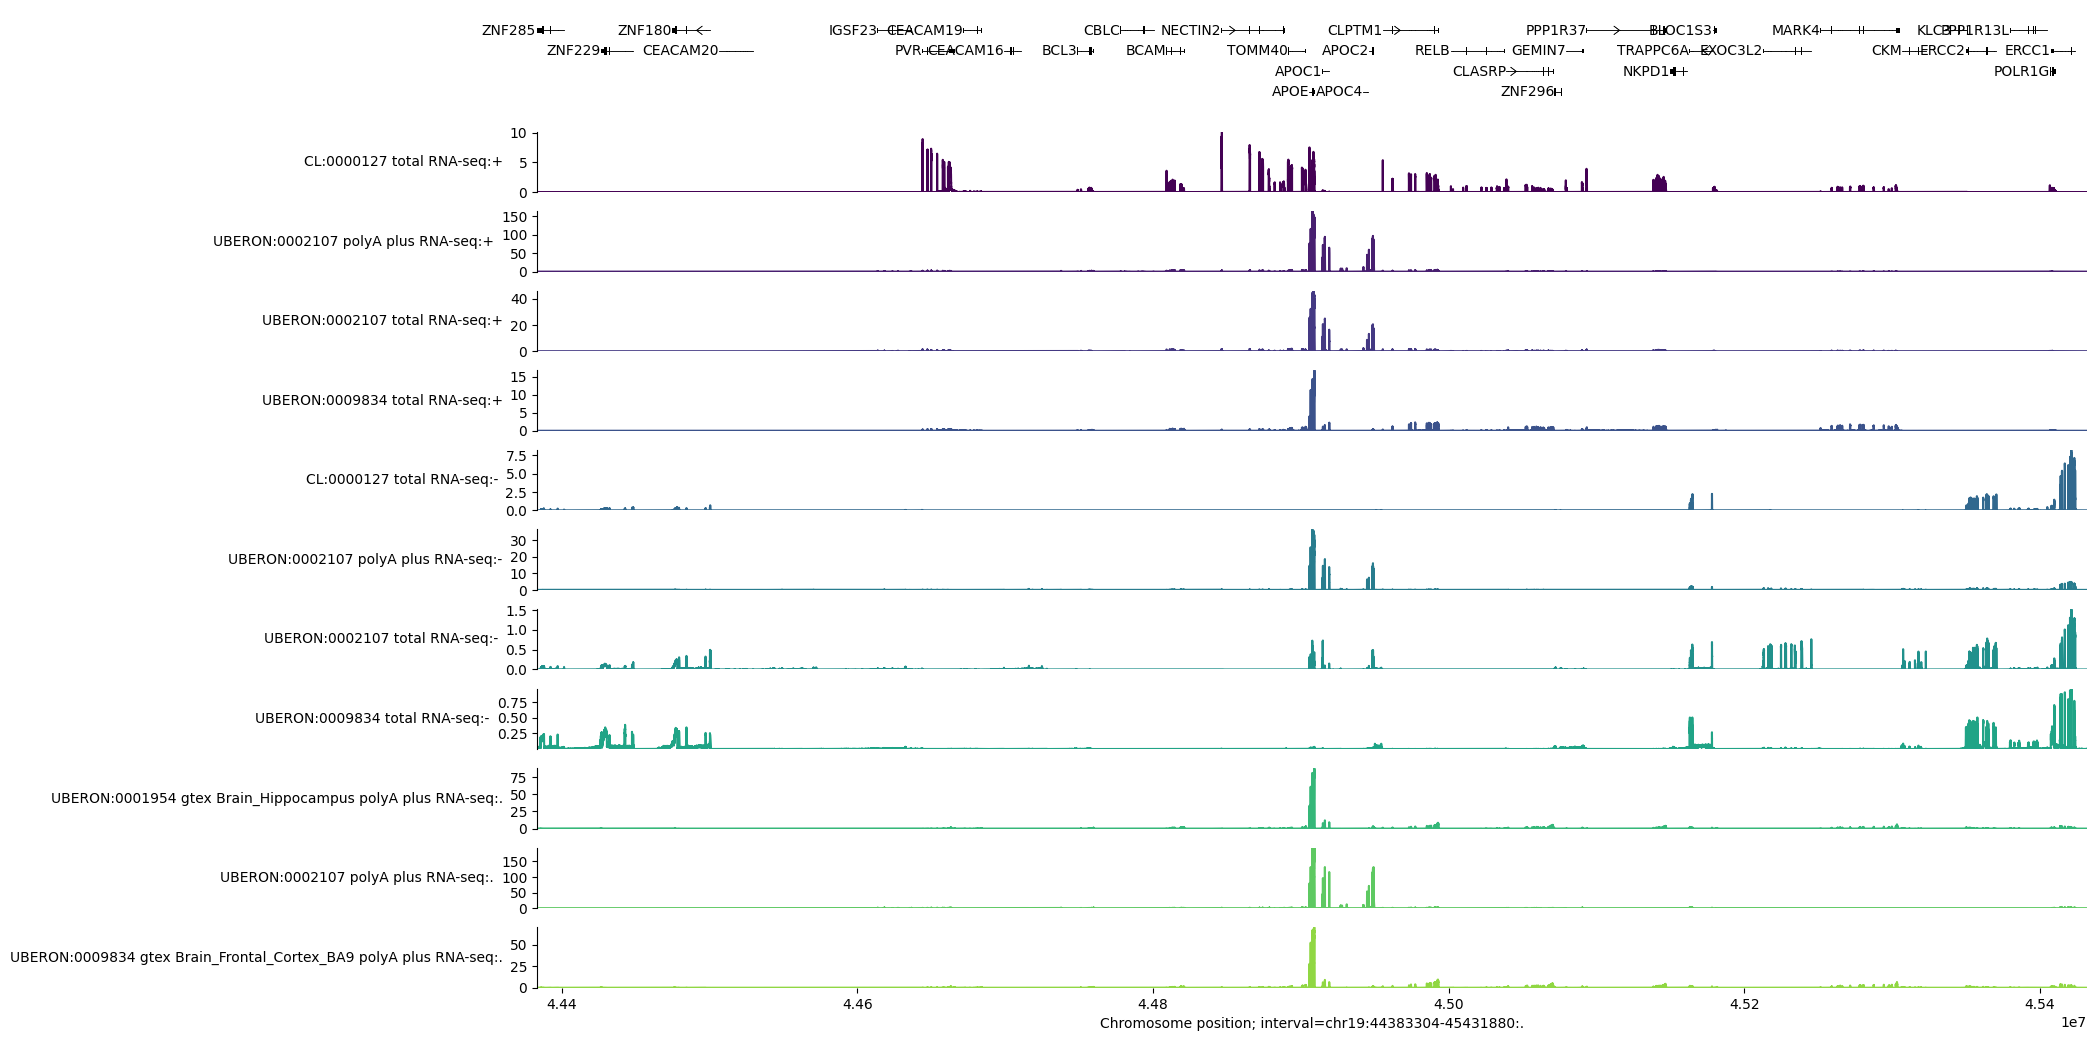

In [39]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval,
)

plt.show()

This plot visualises the 3 predicted RNA-seq tracks and also marks the location
of the MANE select transcript per gene in the 1MB region.

We can zoom in to the middle of the plot by resizing the interval:

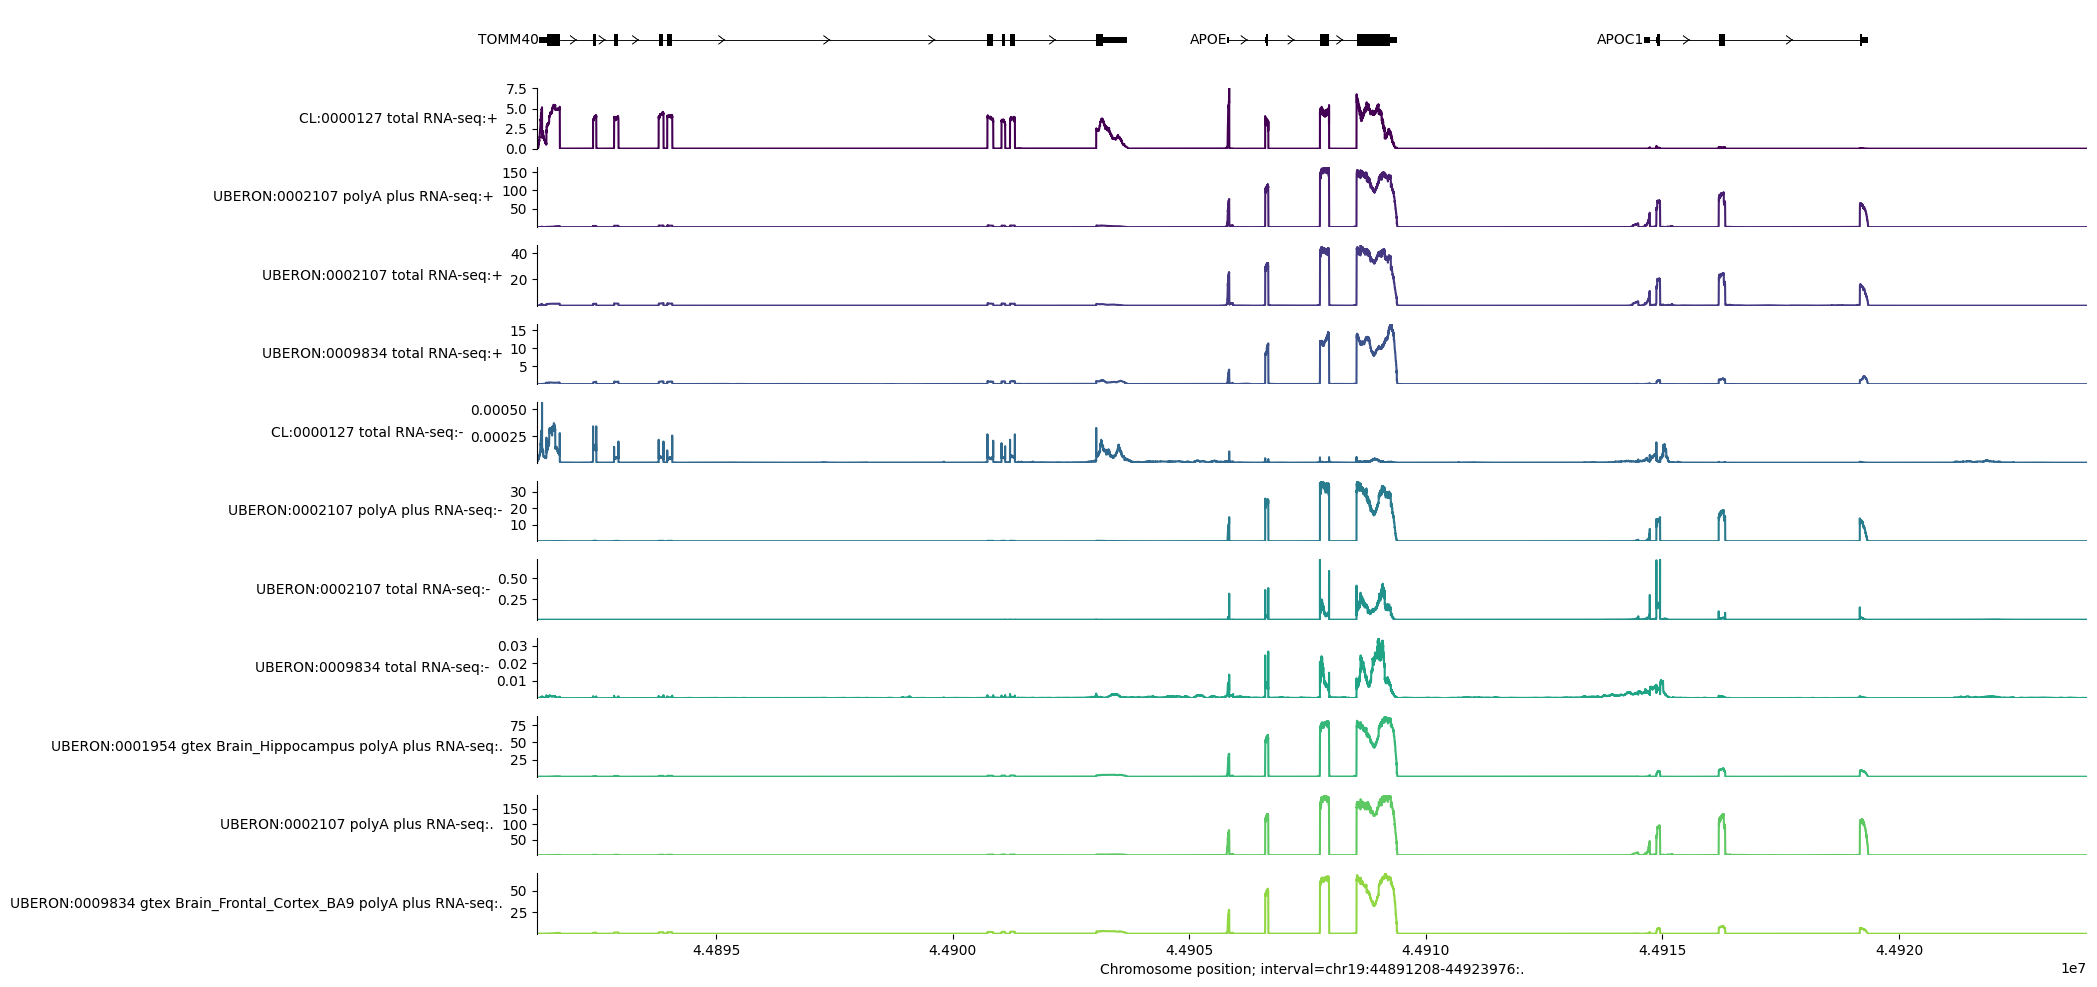

In [40]:
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(
            transcripts, fig_height=0.1
        ),
        plot_components.Tracks(output.rna_seq),
    ],
    interval=output.rna_seq.interval.resize(2**15),
)

plt.show()

You can see here that predicted RNA-seq values are nicely aligned with the
location of exons, and that the predictions are stranded – the predicted values
are much higher for the positive strand, where the gene is located. We see that
the *CYP2B6* gene is on the positive strand since the arrows in the transcript
go from left to right.

For more detail on the visualization library, please refer to the
[visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html)
and
[library documentation](https://www.alphagenomedocs.com/api/visualization.html).

## Predict rs429358 variant effect (APOE4)

In [109]:
data_table.DataTable.max_rows = 100_000
data_table.enable_dataframe_formatter()

# Load the model.
dna_model = dna_client.create(colab_utils.get_api_key())

HG38_GTF_FEATHER = (
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)
MM10_GTF_FEATHER = (
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'mm10/gencode.vM23.annotation.gtf.gz.feather'
)

# Initialize an empty dictionary to serve as a variant effect prediction cache.
_prediction_cache = {}

_transcript_extractor_cache = {}

In [110]:
# @title Score variant { run: "auto" }
organism = 'human'  # @param ["human", "mouse"] {type:"string"}
organism_map = {
    'human': dna_client.Organism.HOMO_SAPIENS,
    'mouse': dna_client.Organism.MUS_MUSCULUS,
}
organism = organism_map[organism]

# @markdown Specify the variant:
variant_chromosome = 'chr19'  # @param { type:"string" }
variant_position = 44908684  # @param { type:"integer" }
variant_reference_bases = 'T'  # @param { type:"string" }
variant_alternate_bases = 'C'  # @param { type:"string" }

variant = genome.Variant(
    chromosome=variant_chromosome,
    position=variant_position,
    reference_bases=variant_reference_bases,
    alternate_bases=variant_alternate_bases,
)

# @markdown Specify length of sequence around variant to predict:
sequence_length = '1MB'  # @param ["2KB", "16KB", "100KB", "500KB", "1MB"] { type:"string" }
sequence_length = dna_client.SUPPORTED_SEQUENCE_LENGTHS[
    f'SEQUENCE_LENGTH_{sequence_length}'
]

# The input interval is derived from the variant (centered on it).
interval = variant.reference_interval.resize(sequence_length)

# @markdown Additional settings:
variant_scores = dna_model.score_variant(
    interval=interval,
    variant=variant,
    variant_scorers=list(variant_scorers.RECOMMENDED_VARIANT_SCORERS.values()),
)

df_scores = variant_scorers.tidy_scores(variant_scores)

download_predictions = False  # @param { type: "boolean" }
if download_predictions:
  df_scores.to_csv(f'{variant}_scores.csv', index=False)
  files.download(f'{variant}_scores.csv')

# @markdown Click `Filter` on the upper right hand side of the interactive dataframe and type a cell or tissue name like "brain" into the `Search by all fields box` to subset the variant scores to a specific tissue of interest:
columns = [
    c for c in df_scores.columns if c not in ['variant_id', 'scored_interval']
]
df_scores[columns]

,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,...,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score
0,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000084 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.023689,0.655252
1,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000100 ATAC-seq,.,...,in_vitro_differentiated_cells,adult,encode,paired,False,NaN,NaN,NaN,0.034040,0.591924
2,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000236 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.013337,0.392960
3,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000623 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.001092,-0.023068
4,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000624 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.018735,0.561129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63966,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR182QNJ,-,...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,0.970564,0.806973
63967,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR740IPL,-,...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,7.135727,0.879127
63968,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR797DEF,-,...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,0.298718,0.656112
63969,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR801ECP,-,...,primary_cell,NaN,encode,NaN,False,NaN,NaN,NaN,0.766516,0.764349


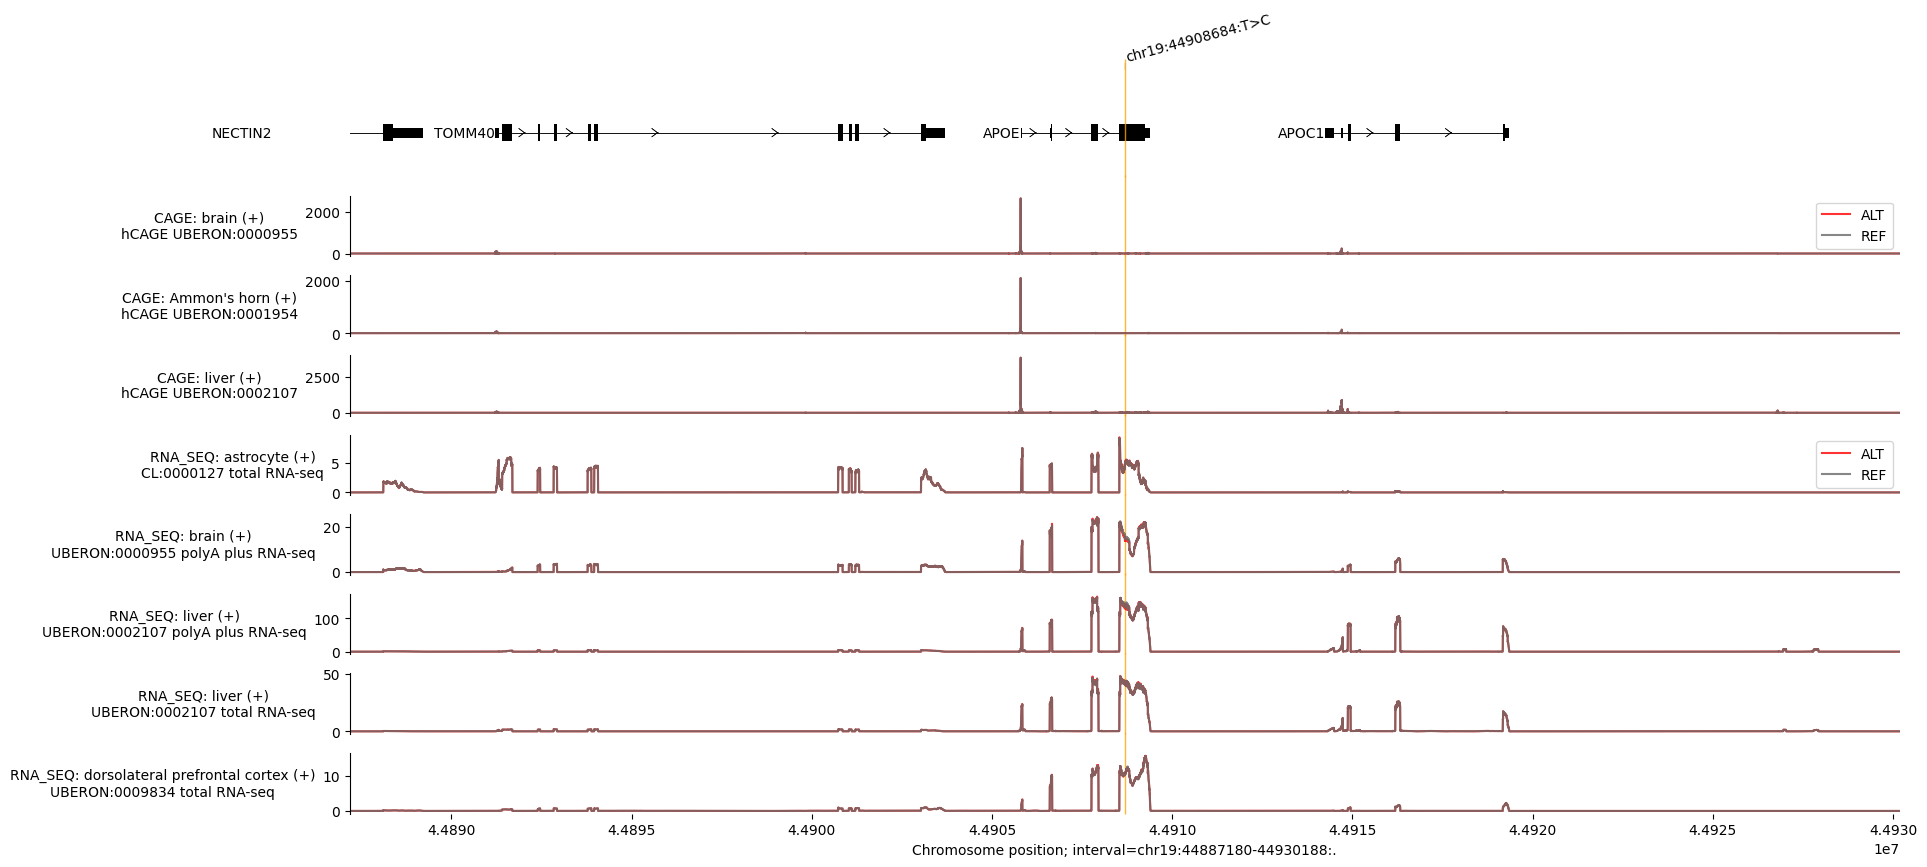

In [117]:
# @title Visualize variant effects { run: "auto" }
# @markdown We can also visualise the predicted effects of the variant by first predicting tracks for the REF and ALT alleles:

# @markdown Specify list of cell and tissue ontologies:
ontology_terms = ['UBERON:0000955', 'UBERON:0009834', 'UBERON:0001954', 'UBERON:0002107', 'CL:0000127']       # @param       # @param

# @markdown Gene and transcript annotation options:
plot_gene_annotation = True  # @param { type: "boolean" }
plot_longest_transcript_only = True  # @param { type: "boolean" }

# @markdown Output types to plot (if present in output):
plot_rna_seq = True  # @param { type: "boolean" }
plot_cage = True  # @param { type: "boolean" }
plot_atac = False  # @param { type: "boolean" }
plot_dnase = False  # @param { type: "boolean" }
plot_chip_histone = False  # @param { type: "boolean" }
plot_chip_tf = False  # @param { type: "boolean" }
plot_splice_sites = False  # @param { type: "boolean" }
plot_splice_site_usage = False  # @param { type: "boolean" }
plot_contact_maps = False  # @param { type: "boolean" }
plot_splice_junctions = False  # @param { type: "boolean" }

# @markdown Option to filter tracks to only a specific DNA strand:
filter_to_positive_strand = True  # @param { type: "boolean" }
filter_to_negative_strand = False  # @param { type: "boolean" }
if filter_to_positive_strand and filter_to_negative_strand:
  raise ValueError(
      'Cannot specify both filter_to_positive_strand and '
      'filter_to_negative_strand.'
  )

# @markdown Specify a list of Transription Factors to select from CHIP_TF outputs e.g. ['IKZF1'].
# These must be contained in the 'transcription_factor' column of the CHIP_TF metadata.
transcription_factors = None  # @param

# @markdown Other visualization options:
ref_color = 'dimgrey'  # @param { type: "string" }
alt_color = 'red'  # @param { type: "string" }
ref_alt_colors = {'REF': ref_color, 'ALT': alt_color}
plot_interval_width = 43008 # @param { type: "slider", min: 2048, max: 1048576, step: 2048}
plot_interval_shift = 0 # @param { type: "slider", min: -524288, max: 524288, step: 2048}


# Load gene annotation.
if organism in _transcript_extractor_cache:
  transcript_extractor, longest_transcript_extractor = (
      _transcript_extractor_cache[organism]
  )
else:
  match organism:
    case dna_client.Organism.HOMO_SAPIENS:
      gtf_path = HG38_GTF_FEATHER
    case dna_client.Organism.MUS_MUSCULUS:
      gtf_path = MM10_GTF_FEATHER
    case _:
      raise ValueError(f'Unsupported organism: {organism}')

  gtf = pd.read_feather(gtf_path)

  # Filter to protein-coding genes and highly supported transcripts.
  gtf_transcript = gene_annotation.filter_transcript_support_level(
      gene_annotation.filter_protein_coding(gtf), ['1']
  )

  # Extractor for identifying transcripts in a region.
  transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcript)

  # Also define an extractor that fetches only the longest transcript per gene.
  gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
      gtf_transcript
  )
  longest_transcript_extractor = transcript_utils.TranscriptExtractor(
      gtf_longest_transcript
  )
  _transcript_extractor_cache[organism] = (
      transcript_extractor,
      longest_transcript_extractor,
  )


def _predict_variant_cached(
    interval, variant, organism, requested_outputs, ontology_terms
):
  """Cache wrapper of dna_model.predict_variant."""
  # Create a unique key from the function arguments.
  cache_key = (
      str(interval),
      str(variant),
      str(organism),
      tuple(requested_outputs),
      tuple(ontology_terms),
  )

  # Check if the result is already in the cache.
  if cache_key in _prediction_cache:
    return _prediction_cache[cache_key]

  # If not, compute the prediction and store it in the cache.
  result = dna_model.predict_variant(
      interval=interval,
      variant=variant,
      organism=organism,
      requested_outputs=requested_outputs,
      ontology_terms=ontology_terms,
  )
  _prediction_cache[cache_key] = result
  return result


output = _predict_variant_cached(
    interval=interval,
    variant=variant,
    organism=organism,
    requested_outputs=[*dna_client.OutputType],
    ontology_terms=ontology_terms,
)

# Filter to DNA strand if requested.
ref, alt = output.reference, output.alternate

if filter_to_positive_strand:
  ref = ref.filter_to_strand(strand='+')
  alt = alt.filter_to_strand(strand='+')
elif filter_to_negative_strand:
  ref = ref.filter_to_strand(strand='-')
  alt = alt.filter_to_strand(strand='-')

# Function to filter to TFs if requested.


def _maybe_filter_to_tfs(
    tdata: track_data.TrackData,
) -> track_data.TrackData | None:
  if not plot_chip_tf:
    return tdata

  if plot_chip_tf and (transcription_factors is not None):
    if not isinstance(transcription_factors, list):
      raise ValueError('TFs must be input as a list of strings.')
    if not isinstance(transcription_factors[0], str):
      raise ValueError('TFs must be input as a list of strings.')

  if transcription_factors is None:
    return tdata

  tf_rows = tdata.metadata.index[
      tdata.metadata['transcription_factor'].isin(transcription_factors)
  ]
  if not tf_rows.any():
    print(
        f'No tracks found for specified transcription factors and'
        f' ontology_terms.'
    )
    return None
  missing_tfs = set(transcription_factors).difference(
      set(tdata.metadata['transcription_factor'])
  )
  if missing_tfs:
    print(
        f'Could not find tracks in chip_tf outputs corresponding to the'
        f' following requested TFs'
    )
  return tdata.select_tracks_by_index(tf_rows)


# Build plot.
components = []

# Gene and transcript annotation.
if plot_gene_annotation:
  if plot_longest_transcript_only:
    transcripts = longest_transcript_extractor.extract(interval)
  else:
    transcripts = transcript_extractor.extract(interval)
  components.append(plot_components.TranscriptAnnotation(transcripts))


# Individual output type plots.
plot_map = {
    'plot_atac': (ref.atac, alt.atac, 'ATAC'),
    'plot_cage': (ref.cage, alt.cage, 'CAGE'),
    'plot_chip_histone': (ref.chip_histone, alt.chip_histone, 'CHIP_HISTONE'),
    'plot_chip_tf': (
        _maybe_filter_to_tfs(ref.chip_tf),
        _maybe_filter_to_tfs(alt.chip_tf),
        'CHIP_TF',
    ),
    'plot_contact_maps': (ref.contact_maps, alt.contact_maps, 'CONTACT_MAPS'),
    'plot_dnase': (ref.dnase, alt.dnase, 'DNASE'),
    'plot_rna_seq': (ref.rna_seq, alt.rna_seq, 'RNA_SEQ'),
    'plot_splice_junctions': (
        ref.splice_junctions,
        alt.splice_junctions,
        'SPLICE_JUNCTIONS',
    ),
    'plot_splice_sites': (ref.splice_sites, alt.splice_sites, 'SPLICE_SITES'),
    'plot_splice_site_usage': (
        ref.splice_site_usage,
        alt.splice_site_usage,
        'SPLICE_SITE_USAGE',
    ),
}

for key, (ref_data, alt_data, output_type) in plot_map.items():
  if eval(key) and ref_data is not None and ref_data.values.shape[-1] == 0:
    print(
        f'Requested plot for output {output_type} but no tracks exist in'
        ' output. This is likely because this output does not exist for your'
        ' ontologies or requested DNA strand.'
    )
  if eval(key) and ref_data and alt_data:
    match output_type:
      case 'CHIP_HISTONE':
        ylabel_template = (
            f'{output_type}: {{biosample_name}} ({{strand}})\n{{histone_mark}}'
        )
      case 'CHIP_TF':
        ylabel_template = (
            f'{output_type}: {{biosample_name}}'
            ' ({strand})\n{transcription_factor}'
        )
      case 'CONTACT_MAPS':
        ylabel_template = f'{output_type}: {{biosample_name}} ({{strand}})'
      case 'SPLICE_SITES':
        ylabel_template = f'{output_type}: {{name}} ({{strand}})'
      case _:
        ylabel_template = (
            f'{output_type}: {{biosample_name}} ({{strand}})\n{{name}}'
        )

    if output_type == 'CONTACT_MAPS':
      component = plot_components.ContactMapsDiff(
          tdata=alt_data - ref_data,
          ylabel_template=ylabel_template,
      )
      components.append(component)
    elif output_type == 'SPLICE_JUNCTIONS':
      ref_plot = plot_components.Sashimi(
          ref_data,
          ylabel_template='REF: ' + ylabel_template,
      )
      alt_plot = plot_components.Sashimi(
          alt_data,
          ylabel_template='ALT: ' + ylabel_template,
      )
      components.extend([ref_plot, alt_plot])
    else:
      component = plot_components.OverlaidTracks(
          tdata={'REF': ref_data, 'ALT': alt_data},
          colors=ref_alt_colors,
          ylabel_template=ylabel_template,
      )
      components.append(component)

if plot_interval_width > interval.width:
  raise ValueError(
      f'plot_interval_width ({plot_interval_width}) must be less than '
      f'interval.width ({interval.width}).'
  )

plot = plot_components.plot(
    components=components,
    interval=interval.shift(plot_interval_shift).resize(plot_interval_width),
    annotations=[
        plot_components.VariantAnnotation([variant]),
    ],
)

In [112]:
# Make predictions for sequences containing the REF and ALT alleles.
output = dna_model.predict_variant(
    interval=interval.resize(2**20),
    variant=variant,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CHIP_HISTONE,
        dna_client.OutputType.DNASE,
    },
    ontology_terms=ontology_terms,
)

It seems no significant changes in rs429358

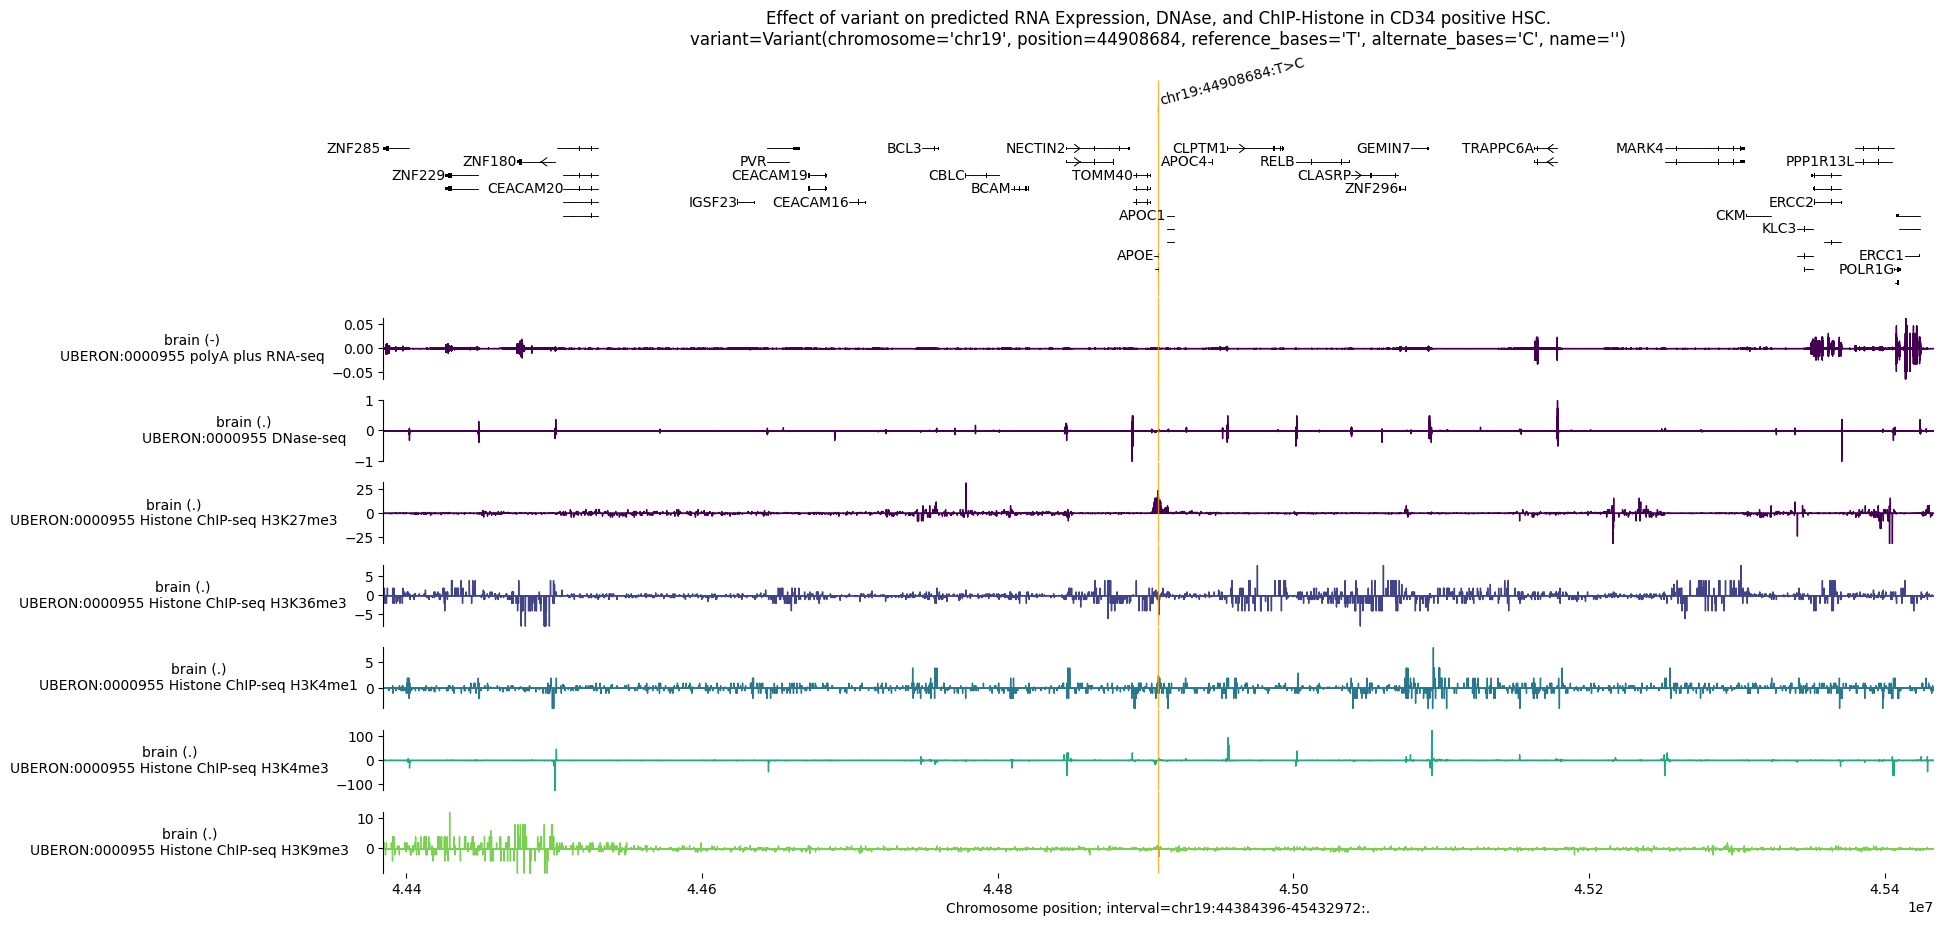

In [113]:
# Build plot.
transcripts = transcript_extractor.extract(interval)
_ = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),
        # RNA-seq tracks.
        plot_components.Tracks(
            tdata=output.alternate.rna_seq.filter_to_nonpositive_strand()
            - output.reference.rna_seq.filter_to_nonpositive_strand(),
            ylabel_template='{biosample_name} ({strand})\n{name}',
            filled=True,
        ),
        # DNAse tracks.
        plot_components.Tracks(
            tdata=output.alternate.dnase.filter_to_nonpositive_strand()
            - output.reference.dnase.filter_to_nonpositive_strand(),
            ylabel_template='{biosample_name} ({strand})\n{name}',
            filled=True,
        ),
        # Chip histone.
        plot_components.Tracks(
            tdata=output.alternate.chip_histone.filter_to_nonpositive_strand()
            - output.reference.chip_histone.filter_to_nonpositive_strand(),
            ylabel_template='{biosample_name} ({strand})\n{name}',
            filled=True,
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=interval,
    title=(
        'Effect of variant on predicted RNA Expression, DNAse, and ChIP-Histone'
        f' in CD34 positive HSC.\n{variant=}'
    ),
)

## Predict rs7412 variant effect (APOE2)

In [58]:
# @title Score variant { run: "auto" }
organism = 'human'  # @param ["human", "mouse"] {type:"string"}
organism_map = {
    'human': dna_client.Organism.HOMO_SAPIENS,
    'mouse': dna_client.Organism.MUS_MUSCULUS,
}
organism = organism_map[organism]

# @markdown Specify the variant:
variant_chromosome = 'chr19'  # @param { type:"string" }
variant_position = 44908822  # @param { type:"integer" }
variant_reference_bases = 'C'  # @param { type:"string" }
variant_alternate_bases = 'T'  # @param { type:"string" }

variant = genome.Variant(
    chromosome=variant_chromosome,
    position=variant_position,
    reference_bases=variant_reference_bases,
    alternate_bases=variant_alternate_bases,
)

# @markdown Specify length of sequence around variant to predict:
sequence_length = '1MB'  # @param ["2KB", "16KB", "100KB", "500KB", "1MB"] { type:"string" }
sequence_length = dna_client.SUPPORTED_SEQUENCE_LENGTHS[
    f'SEQUENCE_LENGTH_{sequence_length}'
]

# The input interval is derived from the variant (centered on it).
interval = variant.reference_interval.resize(sequence_length)

# @markdown Additional settings:
variant_scores = dna_model.score_variant(
    interval=interval,
    variant=variant,
    variant_scorers=list(variant_scorers.RECOMMENDED_VARIANT_SCORERS.values()),
)

df_scores = variant_scorers.tidy_scores(variant_scores)

download_predictions = False  # @param { type: "boolean" }
if download_predictions:
  df_scores.to_csv(f'{variant}_scores.csv', index=False)
  files.download(f'{variant}_scores.csv')

# @markdown Click `Filter` on the upper right hand side of the interactive dataframe and type a cell or tissue name like "brain" into the `Search by all fields box` to subset the variant scores to a specific tissue of interest:
columns = [
    c for c in df_scores.columns if c not in ['variant_id', 'scored_interval']
]
df_scores[columns]

,gene_id,gene_name,gene_type,gene_strand,junction_Start,junction_End,output_type,variant_scorer,track_name,track_strand,...,biosample_type,biosample_life_stage,data_source,endedness,genetically_modified,transcription_factor,histone_mark,gtex_tissue,raw_score,quantile_score
0,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000084 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.014707,0.449849
1,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000100 ATAC-seq,.,...,in_vitro_differentiated_cells,adult,encode,paired,False,NaN,NaN,NaN,-0.003604,-0.137554
2,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000236 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.024918,0.648619
3,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000623 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.021961,0.680793
4,None,None,None,None,None,None,ATAC,"CenterMaskScorer(requested_output=ATAC, width=...",CL:0000624 ATAC-seq,.,...,primary_cell,adult,encode,paired,False,NaN,NaN,NaN,0.009738,0.312224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62498,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR182QNJ,-,...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,0.648619,0.755936
62499,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR740IPL,-,...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,9.760986,0.907554
62500,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR797DEF,-,...,cell_line,NaN,encode,NaN,False,NaN,NaN,NaN,0.186144,0.591254
62501,None,None,None,None,None,None,PROCAP,"CenterMaskScorer(requested_output=PROCAP, widt...",ENCSR801ECP,-,...,primary_cell,NaN,encode,NaN,False,NaN,NaN,NaN,0.510151,0.720300


Requested plot for output ATAC but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
Requested plot for output CHIP_HISTONE but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
Requested plot for output CHIP_TF but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
Requested plot for output CONTACT_MAPS but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.
Requested plot for output DNASE but no tracks exist in output. This is likely because this output does not exist for your ontologies or requested DNA strand.


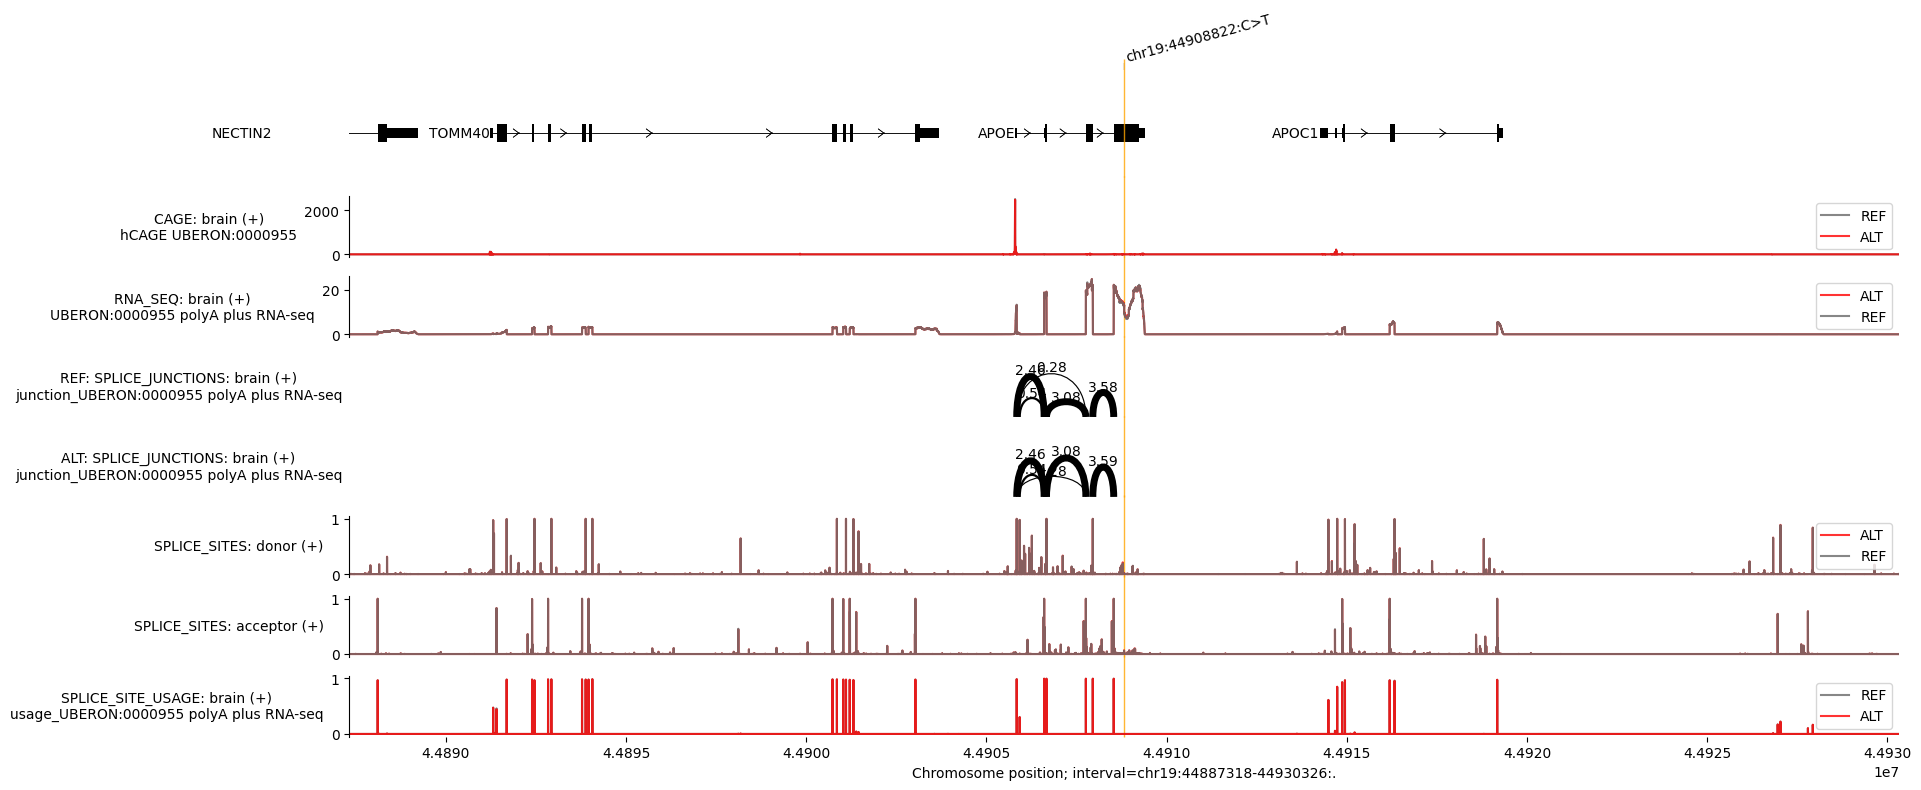

In [71]:
# @title Visualize variant effects { run: "auto" }
# @markdown We can also visualise the predicted effects of the variant by first predicting tracks for the REF and ALT alleles:

# @markdown Specify list of cell and tissue ontologies:
ontology_terms = ['UBERON:0000955']       # @param

# @markdown Gene and transcript annotation options:
plot_gene_annotation = True  # @param { type: "boolean" }
plot_longest_transcript_only = True  # @param { type: "boolean" }

# @markdown Output types to plot (if present in output):
plot_rna_seq = True  # @param { type: "boolean" }
plot_cage = True  # @param { type: "boolean" }
plot_atac = True  # @param { type: "boolean" }
plot_dnase = True  # @param { type: "boolean" }
plot_chip_histone = True  # @param { type: "boolean" }
plot_chip_tf = True  # @param { type: "boolean" }
plot_splice_sites = True  # @param { type: "boolean" }
plot_splice_site_usage = True  # @param { type: "boolean" }
plot_contact_maps = True  # @param { type: "boolean" }
plot_splice_junctions = True  # @param { type: "boolean" }

# @markdown Option to filter tracks to only a specific DNA strand:
filter_to_positive_strand = True  # @param { type: "boolean" }
filter_to_negative_strand = False  # @param { type: "boolean" }
if filter_to_positive_strand and filter_to_negative_strand:
  raise ValueError(
      'Cannot specify both filter_to_positive_strand and '
      'filter_to_negative_strand.'
  )

# @markdown Specify a list of Transription Factors to select from CHIP_TF outputs e.g. ['IKZF1'].
# These must be contained in the 'transcription_factor' column of the CHIP_TF metadata.
transcription_factors = None  # @param

# @markdown Other visualization options:
ref_color = 'dimgrey'  # @param { type: "string" }
alt_color = 'red'  # @param { type: "string" }
ref_alt_colors = {'REF': ref_color, 'ALT': alt_color}
plot_interval_width = 43008 # @param { type: "slider", min: 2048, max: 1048576, step: 2048}
plot_interval_shift = 0 # @param { type: "slider", min: -524288, max: 524288, step: 2048}


# Load gene annotation.
if organism in _transcript_extractor_cache:
  transcript_extractor, longest_transcript_extractor = (
      _transcript_extractor_cache[organism]
  )
else:
  match organism:
    case dna_client.Organism.HOMO_SAPIENS:
      gtf_path = HG38_GTF_FEATHER
    case dna_client.Organism.MUS_MUSCULUS:
      gtf_path = MM10_GTF_FEATHER
    case _:
      raise ValueError(f'Unsupported organism: {organism}')

  gtf = pd.read_feather(gtf_path)

  # Filter to protein-coding genes and highly supported transcripts.
  gtf_transcript = gene_annotation.filter_transcript_support_level(
      gene_annotation.filter_protein_coding(gtf), ['1']
  )

  # Extractor for identifying transcripts in a region.
  transcript_extractor = transcript_utils.TranscriptExtractor(gtf_transcript)

  # Also define an extractor that fetches only the longest transcript per gene.
  gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
      gtf_transcript
  )
  longest_transcript_extractor = transcript_utils.TranscriptExtractor(
      gtf_longest_transcript
  )
  _transcript_extractor_cache[organism] = (
      transcript_extractor,
      longest_transcript_extractor,
  )


def _predict_variant_cached(
    interval, variant, organism, requested_outputs, ontology_terms
):
  """Cache wrapper of dna_model.predict_variant."""
  # Create a unique key from the function arguments.
  cache_key = (
      str(interval),
      str(variant),
      str(organism),
      tuple(requested_outputs),
      tuple(ontology_terms),
  )

  # Check if the result is already in the cache.
  if cache_key in _prediction_cache:
    return _prediction_cache[cache_key]

  # If not, compute the prediction and store it in the cache.
  result = dna_model.predict_variant(
      interval=interval,
      variant=variant,
      organism=organism,
      requested_outputs=requested_outputs,
      ontology_terms=ontology_terms,
  )
  _prediction_cache[cache_key] = result
  return result


output = _predict_variant_cached(
    interval=interval,
    variant=variant,
    organism=organism,
    requested_outputs=[*dna_client.OutputType],
    ontology_terms=ontology_terms,
)

# Filter to DNA strand if requested.
ref, alt = output.reference, output.alternate

if filter_to_positive_strand:
  ref = ref.filter_to_strand(strand='+')
  alt = alt.filter_to_strand(strand='+')
elif filter_to_negative_strand:
  ref = ref.filter_to_strand(strand='-')
  alt = alt.filter_to_strand(strand='-')

# Function to filter to TFs if requested.


def _maybe_filter_to_tfs(
    tdata: track_data.TrackData,
) -> track_data.TrackData | None:
  if not plot_chip_tf:
    return tdata

  if plot_chip_tf and (transcription_factors is not None):
    if not isinstance(transcription_factors, list):
      raise ValueError('TFs must be input as a list of strings.')
    if not isinstance(transcription_factors[0], str):
      raise ValueError('TFs must be input as a list of strings.')

  if transcription_factors is None:
    return tdata

  tf_rows = tdata.metadata.index[
      tdata.metadata['transcription_factor'].isin(transcription_factors)
  ]
  if not tf_rows.any():
    print(
        f'No tracks found for specified transcription factors and'
        f' ontology_terms.'
    )
    return None
  missing_tfs = set(transcription_factors).difference(
      set(tdata.metadata['transcription_factor'])
  )
  if missing_tfs:
    print(
        f'Could not find tracks in chip_tf outputs corresponding to the'
        f' following requested TFs'
    )
  return tdata.select_tracks_by_index(tf_rows)


# Build plot.
components = []

# Gene and transcript annotation.
if plot_gene_annotation:
  if plot_longest_transcript_only:
    transcripts = longest_transcript_extractor.extract(interval)
  else:
    transcripts = transcript_extractor.extract(interval)
  components.append(plot_components.TranscriptAnnotation(transcripts))


# Individual output type plots.
plot_map = {
    'plot_atac': (ref.atac, alt.atac, 'ATAC'),
    'plot_cage': (ref.cage, alt.cage, 'CAGE'),
    'plot_chip_histone': (ref.chip_histone, alt.chip_histone, 'CHIP_HISTONE'),
    'plot_chip_tf': (
        _maybe_filter_to_tfs(ref.chip_tf),
        _maybe_filter_to_tfs(alt.chip_tf),
        'CHIP_TF',
    ),
    'plot_contact_maps': (ref.contact_maps, alt.contact_maps, 'CONTACT_MAPS'),
    'plot_dnase': (ref.dnase, alt.dnase, 'DNASE'),
    'plot_rna_seq': (ref.rna_seq, alt.rna_seq, 'RNA_SEQ'),
    'plot_splice_junctions': (
        ref.splice_junctions,
        alt.splice_junctions,
        'SPLICE_JUNCTIONS',
    ),
    'plot_splice_sites': (ref.splice_sites, alt.splice_sites, 'SPLICE_SITES'),
    'plot_splice_site_usage': (
        ref.splice_site_usage,
        alt.splice_site_usage,
        'SPLICE_SITE_USAGE',
    ),
}

for key, (ref_data, alt_data, output_type) in plot_map.items():
  if eval(key) and ref_data is not None and ref_data.values.shape[-1] == 0:
    print(
        f'Requested plot for output {output_type} but no tracks exist in'
        ' output. This is likely because this output does not exist for your'
        ' ontologies or requested DNA strand.'
    )
  if eval(key) and ref_data and alt_data:
    match output_type:
      case 'CHIP_HISTONE':
        ylabel_template = (
            f'{output_type}: {{biosample_name}} ({{strand}})\n{{histone_mark}}'
        )
      case 'CHIP_TF':
        ylabel_template = (
            f'{output_type}: {{biosample_name}}'
            ' ({strand})\n{transcription_factor}'
        )
      case 'CONTACT_MAPS':
        ylabel_template = f'{output_type}: {{biosample_name}} ({{strand}})'
      case 'SPLICE_SITES':
        ylabel_template = f'{output_type}: {{name}} ({{strand}})'
      case _:
        ylabel_template = (
            f'{output_type}: {{biosample_name}} ({{strand}})\n{{name}}'
        )

    if output_type == 'CONTACT_MAPS':
      component = plot_components.ContactMapsDiff(
          tdata=alt_data - ref_data,
          ylabel_template=ylabel_template,
      )
      components.append(component)
    elif output_type == 'SPLICE_JUNCTIONS':
      ref_plot = plot_components.Sashimi(
          ref_data,
          ylabel_template='REF: ' + ylabel_template,
      )
      alt_plot = plot_components.Sashimi(
          alt_data,
          ylabel_template='ALT: ' + ylabel_template,
      )
      components.extend([ref_plot, alt_plot])
    else:
      component = plot_components.OverlaidTracks(
          tdata={'REF': ref_data, 'ALT': alt_data},
          colors=ref_alt_colors,
          ylabel_template=ylabel_template,
      )
      components.append(component)

if plot_interval_width > interval.width:
  raise ValueError(
      f'plot_interval_width ({plot_interval_width}) must be less than '
      f'interval.width ({interval.width}).'
  )

plot = plot_components.plot(
    components=components,
    interval=interval.shift(plot_interval_shift).resize(plot_interval_width),
    annotations=[
        plot_components.VariantAnnotation([variant]),
    ],
)

No significant changes.

# Highlighting important regions with *in silico* mutagenesis


In [186]:
# # 16KB DNA sequence to use as context when making predictions.
# sequence_interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOE')
# sequence_interval = sequence_interval.resize(dna_client.SEQUENCE_LENGTH_16KB)

# # Mutate all bases in the central 256-base region of the sequence_interval.
# ism_interval = sequence_interval.resize(512)

# # Define the scorer we want to use to score each of the ISM variants
# dnase_variant_scorer = variant_scorers.CenterMaskScorer(
#     requested_output=dna_client.OutputType.DNASE,
#     width=501,
#     aggregation_type=variant_scorers.AggregationType.DIFF_MEAN,
# )

# # Score for all variants
# variant_scores = dna_model.score_ism_variants(
#     interval=sequence_interval,
#     ism_interval=ism_interval,
#     variant_scorers=[dnase_variant_scorer],
# )



# # 1. Define the focus point: The Transcription Start Site (TSS) of APOE
# # GRCh38 TSS for APOE (approximate main isoform start) is chr19:44,905,791
# # Ideally, fetch this dynamically if your gene_annotation object supports .tss
# # tss_position = 44905791
# # center_interval = genome.Interval('chr19', tss_position, tss_position)
# center_interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOE')
# # 2. Create the Context Interval (The "Input" for the model)
# # Resizing around the TSS ensures the promoter is dead-center.
# # Use 196KB if available for better accuracy; otherwise 16KB is okay for local promoter work.
# sequence_interval = center_interval.resize(dna_client.SEQUENCE_LENGTH_1MB)

# # 3. Create the ISM Interval (The "Mutation Zone")
# # We want to mutate 1kb around the TSS to catch all promoter motifs.
# # Your code said "central 256" but used 512. Let's use 1024 (1kb) to be safe.
# ism_interval = center_interval.resize(1024)

# 1. Fetch the Gene Interval (Gene Body)
gene_interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOE')

# 2. Define the TSS (Promoter Anchor)
tss_position = 44905791

# 3. Create the "Combined" Mutation Zone (ISM Interval)
# We want: 0.5kb upstream of TSS (Promoter) --> All the way to the end of the gene
# Note: Check if gene is strictly forward strand. APOE (hg38) is usually forward.
promoter_upstream_dist = 500

combined_start = min(tss_position - promoter_upstream_dist, gene_interval.start)
combined_end = max(tss_position, gene_interval.end)

ism_interval = genome.Interval('chr19', combined_start, combined_end)

sequence_interval = ism_interval.resize(dna_client.SEQUENCE_LENGTH_100KB)

# 4. Define the Scorer with Tissue Specificity
# We filter for Brain (UBERON:0000955) to ensure the scores reflect neuronal regulation.
dnase_variant_scorer = variant_scorers.CenterMaskScorer(
    requested_output=dna_client.OutputType.DNASE,
    width=501,
    aggregation_type=variant_scorers.AggregationType.DIFF_MEAN,
)

# 5. Run ISM
variant_scores = dna_model.score_ism_variants(
    interval=sequence_interval,
    ism_interval=ism_interval,
    variant_scorers=[dnase_variant_scorer],
)

  0%|          | 0/411 [00:00<?, ?it/s]

In [187]:
# Extract DNASE score
def extract_score(adata):
  values = adata.X[:, adata.var['ontology_curie'] == 'UBERON:0000955']
  assert values.size == 1
  return values.flatten()[0]


ism_result = ism.ism_matrix(
    [extract_score(x[0]) for x in variant_scores],
    variants=[v[0].uns['variant'] for v in variant_scores],
)



In [188]:
import pandas as pd
import numpy as np

# 1. Check Dimensions
print(f"Shape of ism_result: {ism_result.shape}")
# EXPECTED: (1024, 4) or similar.
# IF IT IS (4, 1024): You need to transpose it using `ism_result.T`

# 2. Convert to DataFrame to "look" at the data
# We assume the order is usually A, C, G, T.
# If your shape is (1024, 4), use this:
df_ism = pd.DataFrame(ism_result, columns=['A', 'C', 'G', 'T'])

# If your shape was (4, 1024), transpose it first:
# df_ism = pd.DataFrame(ism_result.T, columns=['A', 'C', 'G', 'T'])

print("\n--- Data Preview (First 5 rows) ---")
print(df_ism.head())

print("\n--- Statistics ---")
print(df_ism.describe())

Shape of ism_result: (4102, 4)

--- Data Preview (First 5 rows) ---
          A         C         G    T
0 -0.000000  0.000107  0.000000 -0.0
1 -0.000000 -0.000174  0.000000 -0.0
2 -0.000004  0.000000  0.000000 -0.0
3 -0.000000  0.000000 -0.000222 -0.0
4  0.000000 -0.000000 -0.000242  0.0

--- Statistics ---
                 A            C            G            T
count  4102.000000  4102.000000  4102.000000  4102.000000
mean     -0.000111     0.000016    -0.000143    -0.000148
std       0.009128     0.007444     0.012837     0.008868
min      -0.370616    -0.154343    -0.467082    -0.470988
25%       0.000000     0.000000     0.000000     0.000000
50%      -0.000000     0.000000     0.000000     0.000000
75%       0.000000     0.000000     0.000000     0.000000
max       0.136651     0.171754     0.141538     0.149107


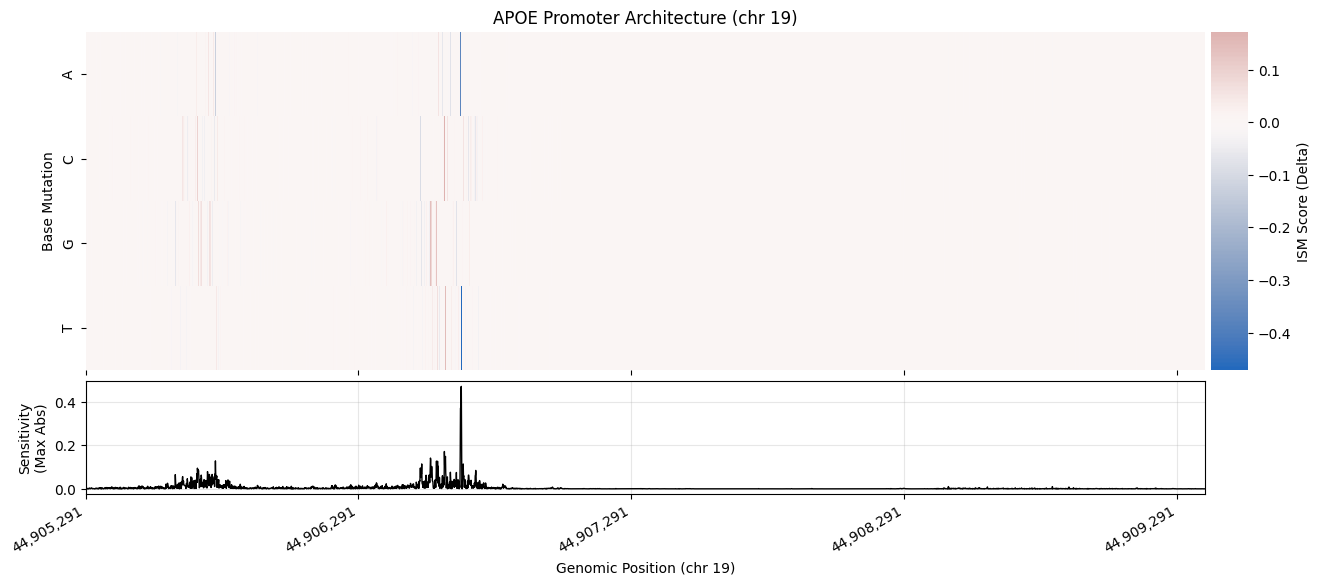

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- DATA PREP (Same as before) ---
# Ensure these match your actual variable names
# ism_result shape: (1024, 4) or similar
# ism_interval: Your interval object

df_ism = pd.DataFrame(ism_result.T, index=['A', 'C', 'G', 'T'])
importance_track = np.max(np.abs(ism_result), axis=1)

start_coord = ism_interval.start
tick_step = 1000
tick_indices = np.arange(0, ism_result.shape[0], tick_step)
tick_labels = [f"{start_coord + i:,}" for i in tick_indices]

# --- PLOTTING WITH ALIGNMENT FIX ---

fig = plt.figure(figsize=(15, 6))

# Define a grid: 2 rows, 2 columns.
# Column 0 is the Main Plot (Wide). Column 1 is the Colorbar (Narrow).
gs = fig.add_gridspec(2, 2,  width_ratios=[30, 1], height_ratios=[3, 1], wspace=0.01, hspace=0.05)

# Create the axes based on this grid
ax_heatmap = fig.add_subplot(gs[0, 0])
ax_line = fig.add_subplot(gs[1, 0], sharex=ax_heatmap) # Link X-axis here!
ax_cbar = fig.add_subplot(gs[0, 1]) # Dedicated axis for the colorbar

# --- TOP PLOT: HEATMAP ---
sns.heatmap(
    df_ism,
    cmap="vlag",
    center=0,
    ax=ax_heatmap,
    cbar_ax=ax_cbar, # <--- KEY FIX: Tell Seaborn to put legend here
    cbar_kws={'label': 'ISM Score (Delta)'},
    xticklabels=False
)
ax_heatmap.set_title(f"APOE Promoter Architecture (chr 19)")
ax_heatmap.set_ylabel("Base Mutation")
ax_heatmap.set_xlabel("")

# --- BOTTOM PLOT: SENSITIVITY ---
ax_line.plot(importance_track, color='black', linewidth=1)
ax_line.set_ylabel("Sensitivity\n(Max Abs)")
ax_line.set_xlabel(f"Genomic Position (chr 19)")
ax_line.margins(x=0)
ax_line.grid(True, alpha=0.3)

# --- FORMATTING TICKS ---
ax_line.set_xticks(tick_indices)
ax_line.set_xticklabels(tick_labels, rotation=30, ha='right')

plt.setp(ax_heatmap.get_xticklabels(), visible=False)


plt.show()

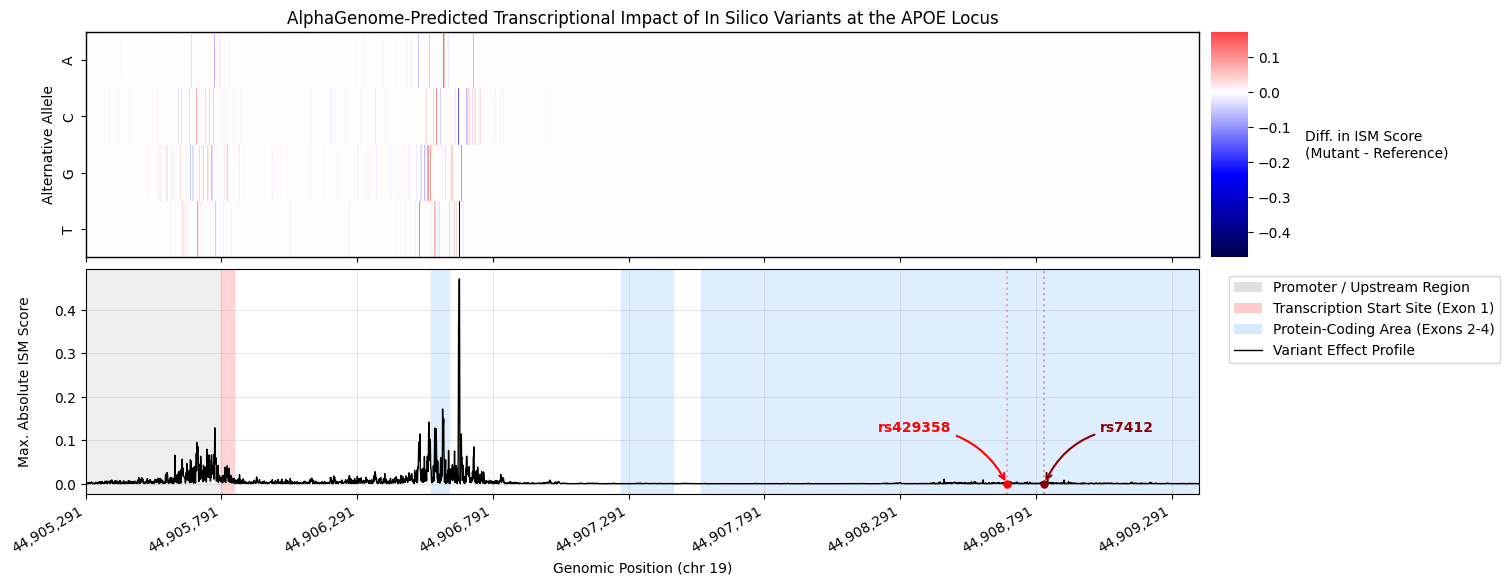

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yao/Desktop/RIFL/AlphaGenome/AlphaGenome-Predicted.png/myimage.png'

<Figure size 640x480 with 0 Axes>

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.colors import SymLogNorm

# =========================================
# 1. SETUP DATA & INTERVALS
# =========================================

# --- HELPER CLASS ---
class Interval:
    def __init__(self, chrom, start, end):
        self.chrom, self.start, self.end = chrom, int(start), int(end)

# --- YOUR DATA ---
# Assuming ism_result and ism_interval exist from previous steps
df_ism = pd.DataFrame(ism_result.T, index=['A', 'C', 'G', 'T'])
importance_track = np.max(np.abs(ism_result), axis=1)
ism_start = ism_interval.start
N = len(importance_track)

# --- DEFINE ZONES (hg38) ---
zone_tss = Interval('chr19', 44905791, 44905837)
zones_coding = [
    Interval('chr19', 44906565, 44906631),
    Interval('chr19', 44907264, 44907453),
    Interval('chr19', 44907558, 44909393),
]

def to_idx(coord):
    return max(0, min(N, coord - ism_start))

# =========================================
# 2. PLOTTING
# =========================================
tick_step = 500
tick_indices = np.arange(0, N, tick_step)
tick_labels = [f"{ism_start + i:,}" for i in tick_indices]

fig = plt.figure(figsize=(15, 6))
# Adjusted width_ratios to give a bit more room for the new outside legend
gs = fig.add_gridspec(2, 2, width_ratios=[30, 1], height_ratios=[1, 1], wspace=0.02, hspace=0.05)
ax_heatmap = fig.add_subplot(gs[0, 0])
ax_line = fig.add_subplot(gs[1, 0], sharex=ax_heatmap)
ax_cbar = fig.add_subplot(gs[0, 1])

# --- TOP PLOT: HEATMAP ---
sns.heatmap(
    df_ism, cmap="seismic", center=0, ax=ax_heatmap, cbar_ax=ax_cbar,
    cbar_kws = {}, xticklabels=False,
    vmin=np.min(ism_result), vmax=np.max(ism_result)
)
for _, spine in ax_heatmap.spines.items():
    spine.set_visible(True)
    spine.set_linewidth(1)
    spine.set_edgecolor('black')
cbar = ax_heatmap.collections[0].colorbar
cbar.ax.set_ylabel(
    'Diff. in ISM Score\n(Mutant - Reference)',
    rotation=0,
    va="center",
    ha="left",             # Aligns the text block to the left relative to the anchor
    multialignment="left", # Aligns the two lines of text to the left relative to each other
    labelpad=10            # Adjusts distance from the colorbar
)
ax_heatmap.set_title(f"AlphaGenome-Predicted Transcriptional Impact of In Silico Variants at the APOE Locus")
ax_heatmap.set_ylabel("Alternative Allele")
ax_heatmap.set_xlabel("")
plt.setp(ax_heatmap.get_xticklabels(), visible=False)

# --- BOTTOM PLOT: LINE & BACKGROUND ---

# 1. Plot Data
ax_line.plot(importance_track, color='black', linewidth=1, label='Sensitivity')

# 2. Shade Backgrounds
tss_idx = to_idx(zone_tss.start)
if tss_idx > 0:
    ax_line.axvspan(0, tss_idx, color='#e0e0e0', alpha=0.5, zorder=0)

start, end = to_idx(zone_tss.start), to_idx(zone_tss.end)
ax_line.axvspan(start, end, color='#ffcccb', alpha=0.8, zorder=0)

for zone in zones_coding:
    start, end = to_idx(zone.start), to_idx(zone.end)
    if end > start:
        ax_line.axvspan(start, end, color='#d6eaff', alpha=0.8, zorder=0)

# --- D. IMPROVED SNP ANNOTATIONS WITH ANGLED ARROWS ---
snps = [
    # xytext is in 'offset points' from the target.
    # (-80, 30) moves text left and up. 'arc3,rad=-0.3' curves it left.
    {'rsid': 'rs429358', 'pos': 44908684, 'color': 'red', 'xytext': (-40, 35), 'rad': -0.3, 'ha': 'right'},
    # (80, 30) moves text right and up. 'arc3,rad=0.3' curves it right.
    {'rsid': 'rs7412',   'pos': 44908822, 'color': 'darkred', 'xytext': (40, 35), 'rad': 0.3, 'ha': 'left'}
]

for snp in snps:
    idx = to_idx(snp['pos'])
    if 0 <= idx < N:
        # Dot on the axis
        ax_line.scatter([idx], [0], color=snp['color'], s=25, zorder=10, marker='o')

        # Angled Annotation
        ax_line.annotate(
            snp['rsid'],
            xy=(idx, 0),
            xycoords='data',
            xytext=snp['xytext'],
            textcoords='offset points',
            arrowprops=dict(
                facecolor=snp['color'], edgecolor=snp['color'],
                arrowstyle='->', lw=1.5,
                connectionstyle=f"arc3,rad={snp['rad']}" # Creates the curve
            ),
            color=snp['color'], fontsize=10, fontweight='bold', ha=snp['ha'], va='bottom'
        )
        ax_line.axvline(idx, color=snp['color'], linestyle=':', alpha=0.3)

# Formatting
ax_line.set_ylabel("Max. Absolute ISM Score\n")
ax_line.set_xlabel(f"Genomic Position (chr 19)")
ax_line.margins(x=0)
ax_line.grid(True, alpha=0.3)
ax_line.set_xticks(tick_indices)
ax_line.set_xticklabels(tick_labels, rotation=30, ha='right')

# --- LEGEND MOVED OUTSIDE ---
legend_elements = [
    Patch(facecolor='#e0e0e0', label='Promoter / Upstream Region'),
    Patch(facecolor='#ffcccb', label='Transcription Start Site (Exon 1)'),
    Patch(facecolor='#d6eaff', label='Protein-Coding Area (Exons 2-4)'),
    plt.Line2D([0], [0], color='black', lw=1, label='Variant Effect Profile'),
]
# bbox_to_anchor=(1.02, 1) places the top-left corner of the legend
# just outside the top-right corner of the axes.
ax_line.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=True)

plt.setp(ax_heatmap.get_xticklabels(), visible=False)

plt.show()
plt.savefig('/Users/yao/Desktop/RIFL/AlphaGenome/AlphaGenome-Predicted.png/myimage.png', dpi=300, bbox_inches="tight")